# Mohammad Amin Rami

# Student ID: 98101588
## Deep Learning HW2
## Question 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import numpy as np
from torch.utils.data import DataLoader

### Part A

In [2]:
def one_hot(label):
    y = torch.zeros((1, 10))
    y[0, label] = 1
    return y

batch_size = 16

train_set = torchvision.datasets.FashionMNIST(
    root='Data/HW2_data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform = one_hot
)
test_set = torchvision.datasets.FashionMNIST(
    root='Data/HW2_data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform = one_hot
)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


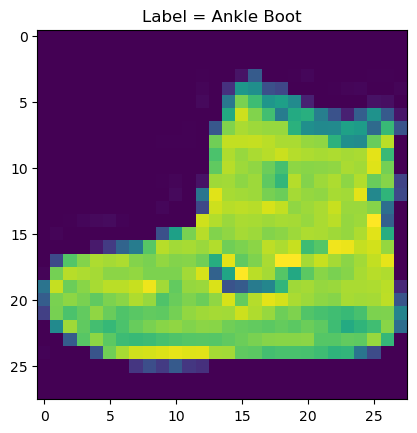

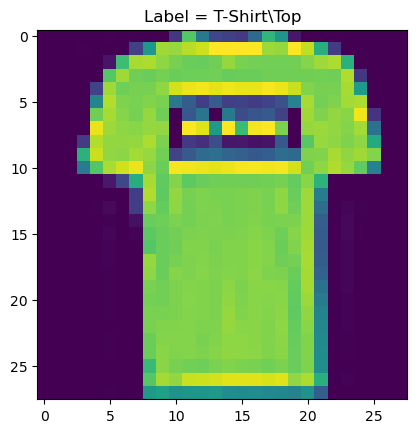

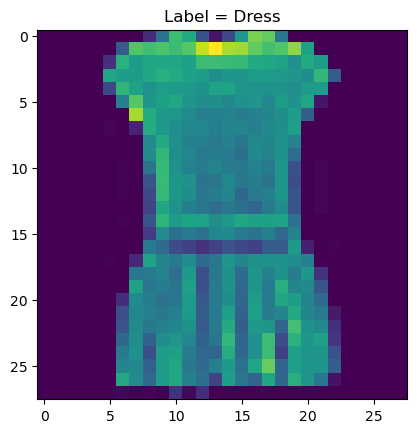

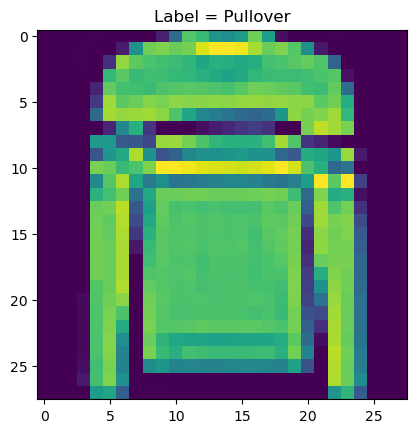

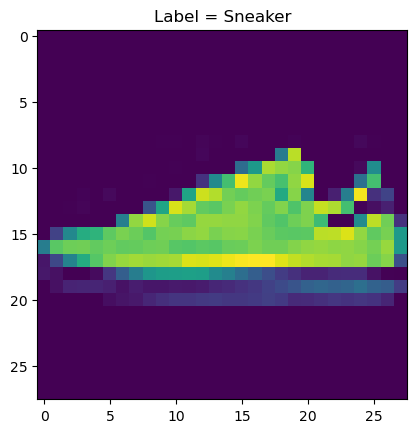

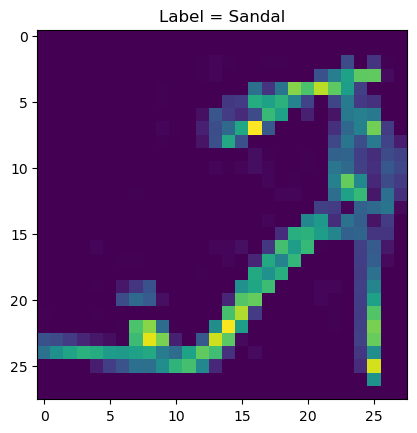

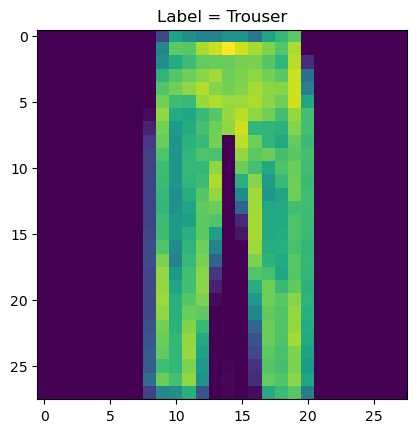

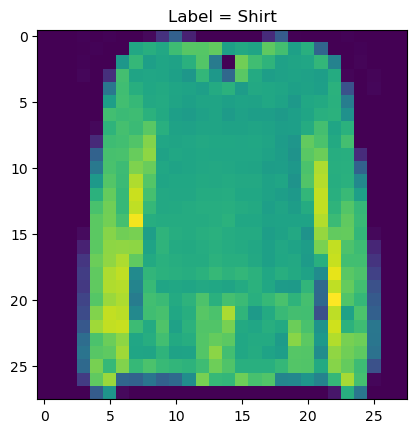

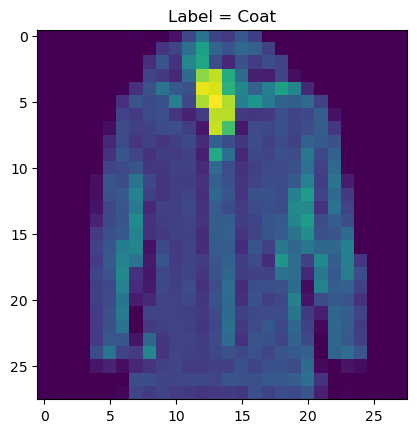

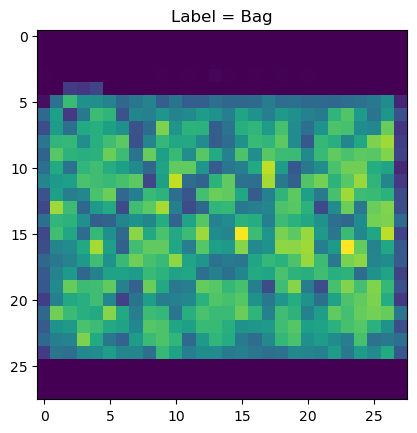

In [3]:
label_map = {
    0: "T-Shirt\Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

has_not_appeared = [True for _ in range(10)]
train_set_iter = iter(train_set)
while any(has_not_appeared):
    img, label = next(train_set_iter)
    label = int(label.argmax())
    if has_not_appeared[label]:
        plt.imshow(img.squeeze())
        plt.title(f"Label = {label_map[label]}")
        plt.show()
        has_not_appeared[label] = False


### Part B

In [4]:
class Linear:
    def __init__(self, size):
        self.w = torch.randn(size, requires_grad=True)
        self.b = torch.randn((1, size[1]), requires_grad=True)
    
    def __call__(self, X):
        y = X @ self.w + self.b
        return y
    
    def update(self, lr):
        with torch.no_grad():
            self.w -= lr * self.w.grad/torch.norm(self.w.grad)
            self.b -= lr * self.b.grad/torch.norm(self.b.grad)
            self.w.grad.zero_()
            self.b.grad.zero_()


class ReLu(Linear):    
    def __call__(self, X):
        y = X @ self.w + self.b
        y[y < 0] = 0 
        return y

    
class SoftMax:
    def __call__(self, X):
        row_sum = torch.sqrt((X * X).sum(dim=1)).reshape((-1, 1))
        X = X/row_sum
        exp_X = torch.exp(X)
        return exp_X/exp_X.sum(dim=1).reshape((-1, 1))


class NeuralNetwork:
    def __init__(self):
        self.relu1 = ReLu((784, 512))
        self.relu2 = ReLu((512, 256))
        self.relu3  = ReLu((256, 128))
        self.relu4 = ReLu((128, 64))
        self.linear = Linear((64, 10))
        self.soft = SoftMax()
    
    def __call__(self, x):
        x = self.relu1(x)
        x = self.relu2(x)
        x = self.relu3(x)
        x = self.relu4(x)
        x = self.linear(x)
        x = self.soft(x)
        return x
    
    def learn(self, lr):
        self.relu1.update(lr)
        self.relu2.update(lr)
        self.relu3.update(lr)
        self.relu4.update(lr)
        self.linear.update(lr)    


In [5]:
def loss_fn(gnd_truth, pred, batch_size):
    loss = torch.mul(gnd_truth, pred.log2())
    loss = -loss.sum()/batch_size
    return loss


### Part C

In [6]:
def train_loop(model, loss_fn, lr, train_dataloader, batch_size):
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    correct = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.squeeze().reshape((batch_size, 28*28))
        y = y.squeeze().reshape((batch_size, -1))
        pred = model(X)
        loss = loss_fn(y, pred, batch_size)
        loss.backward()
        model.learn(lr)
        correct += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        
        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    print(f'Train Accuracy: {(100*correct):>0.1f}%')
    return correct
        

In [7]:
def test_loop(model, loss_fn, test_dataloader, batch_size):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    correct = 0
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.squeeze().reshape((batch_size, 28*28))
            y = y.squeeze().reshape((batch_size, -1))
            pred = model(X)
            correct += (pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    correct /= size
    
    print(f"Test Accuracy: {(100*correct):>0.1f}%")
    return correct

In [8]:
model = NeuralNetwork()

In [9]:
epochs = 20
lr = 0.01

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_acc = train_loop(model, loss_fn, lr, train_dataloader, batch_size)
    test_acc = test_loop(model, loss_fn, test_dataloader, batch_size)
print("Done!")

Epoch 1
-------------------------------
train loss: 3.433986  [    0/60000]
train loss: 2.900157  [ 6400/60000]
train loss: 2.713675  [12800/60000]
train loss: 2.625440  [19200/60000]
train loss: 2.468096  [25600/60000]
train loss: 2.634928  [32000/60000]
train loss: 2.401380  [38400/60000]
train loss: 2.393063  [44800/60000]
train loss: 2.490110  [51200/60000]
train loss: 2.585771  [57600/60000]
Train Accuracy: 62.6%
Test Accuracy: 73.2%
Epoch 2
-------------------------------
train loss: 2.395213  [    0/60000]
train loss: 2.610026  [ 6400/60000]
train loss: 2.540363  [12800/60000]
train loss: 2.266419  [19200/60000]
train loss: 2.508901  [25600/60000]
train loss: 2.580867  [32000/60000]
train loss: 2.426185  [38400/60000]
train loss: 2.303270  [44800/60000]
train loss: 2.479557  [51200/60000]
train loss: 2.382951  [57600/60000]
Train Accuracy: 76.2%
Test Accuracy: 77.3%
Epoch 3
-------------------------------
train loss: 2.420566  [    0/60000]
train loss: 2.244647  [ 6400/60000]
tr

train loss: 2.354074  [32000/60000]
train loss: 2.210673  [38400/60000]
train loss: 2.372725  [44800/60000]
train loss: 2.330021  [51200/60000]
train loss: 2.236496  [57600/60000]
Train Accuracy: 85.8%
Test Accuracy: 84.0%
Epoch 20
-------------------------------
train loss: 2.315260  [    0/60000]
train loss: 2.219926  [ 6400/60000]
train loss: 2.386535  [12800/60000]
train loss: 2.277425  [19200/60000]
train loss: 2.205061  [25600/60000]
train loss: 2.195976  [32000/60000]
train loss: 2.195118  [38400/60000]
train loss: 2.131215  [44800/60000]
train loss: 2.136946  [51200/60000]
train loss: 2.086247  [57600/60000]
Train Accuracy: 86.1%
Test Accuracy: 84.2%
Done!


### Part D

In [11]:
print('------ Model Performance Report ------')
print(f'Train Accuracy:    {(100*train_acc):>0.1f}%')
print(f'Test Accuracy:    {(100*test_acc):>0.1f}%')

------ Model Performance Report ------
Train Accuracy:    86.1%
Test Accuracy:    84.2%


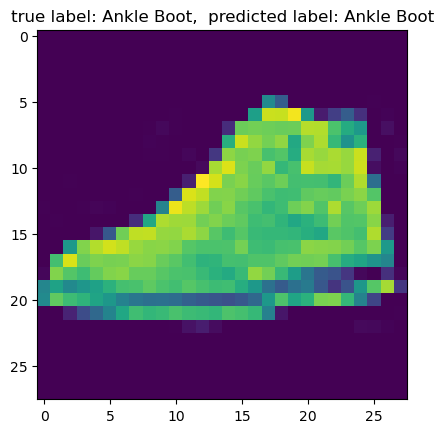

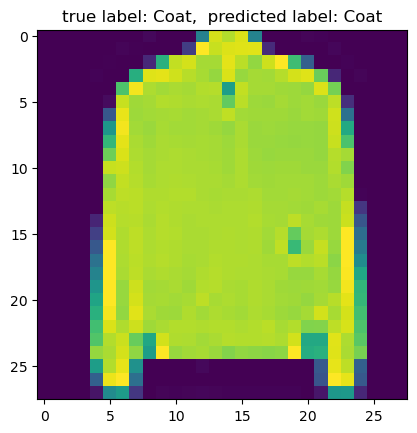

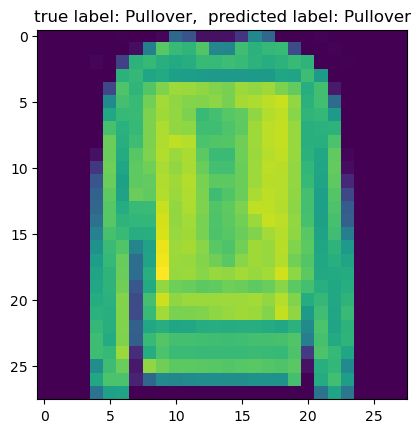

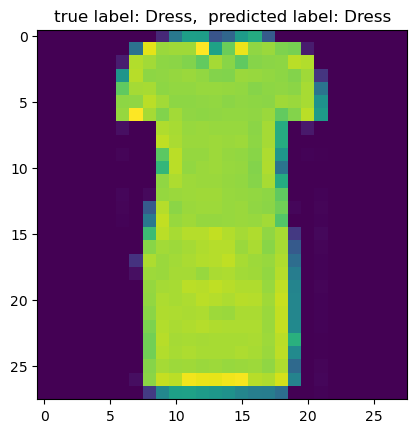

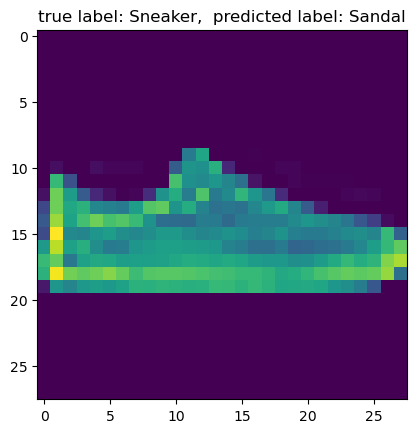

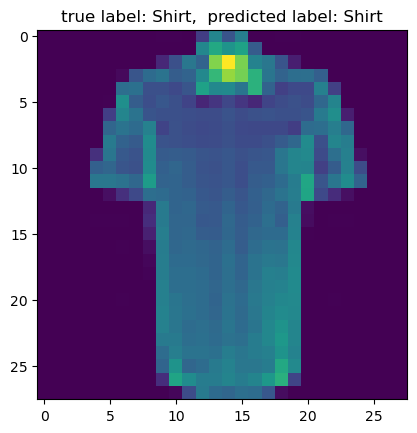

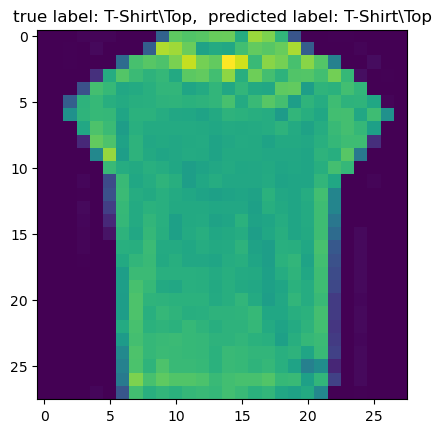

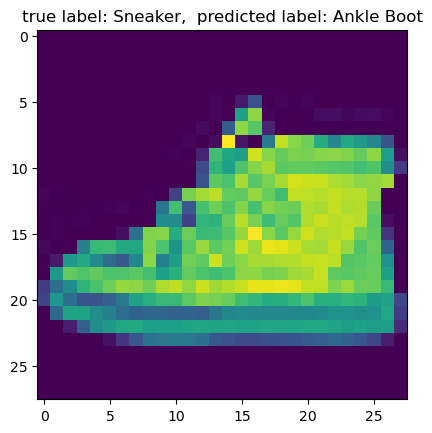

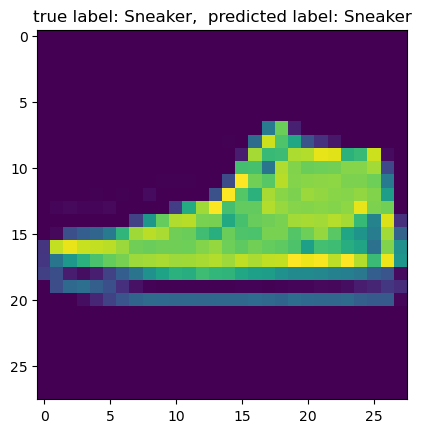

In [18]:
from random import choice

for _ in range(9):
    img, y = choice(test_set)
    X = img.squeeze().reshape((-1, 28*28))
    y = y.squeeze().reshape((-1, 10))
    pred = model(X)
    
    true_label = int(y.argmax(dim=1).item())
    pred_label = int(pred.argmax(dim=1).item())
    
    plt.imshow(img.squeeze())
    plt.title(f'true label: {label_map[true_label]},  predicted label: {label_map[pred_label]}')
    plt.show()
    